In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.7.0


### Define PINN neural network

In [5]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    
    def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(1))

        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))

        model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))

        return model

    # Initialize the class
    def __init__(self, X_u, Y_u, X_r):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = self.init_model()
        
        self.iter = 1
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1+loss_2+loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        del tape
        
        return loss, g, g_u, g_r

        # Compute gradient projections.
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 2000 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
#             if i%10000 == 0:
#                 self.weights_log.append(PINN_solver.model.get_weights())
#                 self.gradients_log.append([grad_theta, g_u, g_r])
                
    def predict(self, x_star):
        mu, sigma = self.mu_x, self.sigma_x
        x_star_normalized = (x_star-mu)/sigma
        
        return self.model(x_star_normalized)

### Generate training data

In [6]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 5000                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([60000.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [7]:
N = 80000

### Train PINN without PCGrad

In [8]:
PINN_solver = PINN(x_u, y_u, x_r)
initial_weights = PINN_solver.model.get_weights()

In [9]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 02000: loss = 2.325651e-06,1.0838815e-08
Iteration 04000: loss = 4.2785715e-07,1.1512327e-08
Iteration 06000: loss = 1.207714e-07,1.1984464e-08
Iteration 08000: loss = 3.9250622e-08,1.23808555e-08
Iteration 10000: loss = 1.3649248e-08,1.272671e-08
Iteration 12000: loss = 5.0040456e-09,1.30113325e-08
Iteration 14000: loss = 1.9675968e-09,1.3187691e-08
Iteration 16000: loss = 8.7525126e-10,1.3160637e-08
Iteration 18000: loss = 4.8119914e-10,1.2787892e-08
Iteration 20000: loss = 3.598889e-10,1.187139e-08
Iteration 22000: loss = 3.5605938e-10,1.0274466e-08
Iteration 24000: loss = 3.54931e-10,8.385003e-09
Iteration 26000: loss = 3.4269534e-10,6.860028e-09
Iteration 28000: loss = 3.175237e-10,6.013237e-09
Iteration 30000: loss = 2.9107475e-10,5.6067693e-09
Iteration 32000: loss = 2.712832e-10,5.400961e-09
Iteration 34000: loss = 2.569904e-10,5.276727e-09
Iteration 36000: loss = 2.461018e-10,5.1826605e-09
Iteration 38000: loss = 2.389303e-10,5.100913e-09
Iteration 40000: loss = 2.30

### Train PINN with PCGrad

In [10]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r)
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [11]:
%%time

optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 02000: loss = 5.2723237e-05,2.5654912e-09
Iteration 04000: loss = 2.1895257e-05,1.3075176e-09
Iteration 06000: loss = 2.1487622e-06,1.0184493e-09
Iteration 08000: loss = 7.635378e-07,8.1298146e-10
Iteration 10000: loss = 5.7252123e-07,5.662999e-10
Iteration 12000: loss = 1.3341497e-06,1.12535585e-10
Iteration 14000: loss = 1.435495e-07,1.3449784e-10
Iteration 16000: loss = 4.0363343e-08,1.4159454e-10
Iteration 18000: loss = 1.2764892e-08,1.4710615e-10
Iteration 20000: loss = 4.3459605e-09,1.5198129e-10
Iteration 22000: loss = 1.7124117e-09,1.5519452e-10
Iteration 24000: loss = 8.3673274e-10,1.5571648e-10
Iteration 26000: loss = 4.853724e-10,1.5466464e-10
Iteration 28000: loss = 3.079377e-10,1.5384422e-10
Iteration 30000: loss = 2.0594715e-10,1.5377273e-10
Iteration 32000: loss = 1.4929023e-10,1.5397456e-10
Iteration 34000: loss = 1.1291915e-10,1.5432453e-10
Iteration 36000: loss = 9.197837e-11,1.5445956e-10
Iteration 38000: loss = 7.5460284e-11,1.5464063e-10
Iteration 40000: 

### Visualize layer gradients

In [13]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# sns.kdeplot(PINN_solver.gradients_log[0][1][0].numpy().flatten(), linewidth =2, ax = axs[0][0], 
#             label = r'$\nabla_\mathcal{\theta}\mathcal{L}_u$')
# axs[0][0].legend()


# sns.kdeplot(PINN_solver.gradients_log[0][2][0].numpy().flatten(), linewidth =2, ax = axs[0][1], 
#             label = r'$\nabla_\mathcal{\theta}\mathcal{L}_f$')
# axs[0][1].legend()


# sns.kdeplot(PINN_solver.gradients_log[2][1][0].numpy().flatten(), linewidth =2, ax = axs[1][0], 
#             label = r'$\nabla_\mathcal{\theta}\mathcal{L}_u$')
# axs[1][0].legend()


# sns.kdeplot(PINN_solver.gradients_log[2][2][0].numpy().flatten(), linewidth =2, ax = axs[1][1], 
#             label = r'$\nabla_\mathcal{\theta}\mathcal{L}_f$')
# axs[1][1].legend()

# plt.tight_layout()
# plt.legend()

In [42]:
# fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# sns.kdeplot(PINN_solver.gradients_log[1][2][0].numpy().flatten(), ax = axs, linewidth =2,
#             label = r'$\Delta_\mathcal{\theta}\mathcal{L}_r$')

# sns.kdeplot(PINN_solver.gradients_log[1][1][0].numpy().flatten(), linewidth =2, ax = axs, 
#             label = r'$\Delta_\mathcal{\theta}\mathcal{L}_u$')

# plt.tight_layout()
# plt.legend()

### Visualize loss function

In [15]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Loss convergence comparison

In [16]:
iterations_range = np.array(range(len(pinn_pcgrad_loss_log[50000:52000, 1]))) + 50000

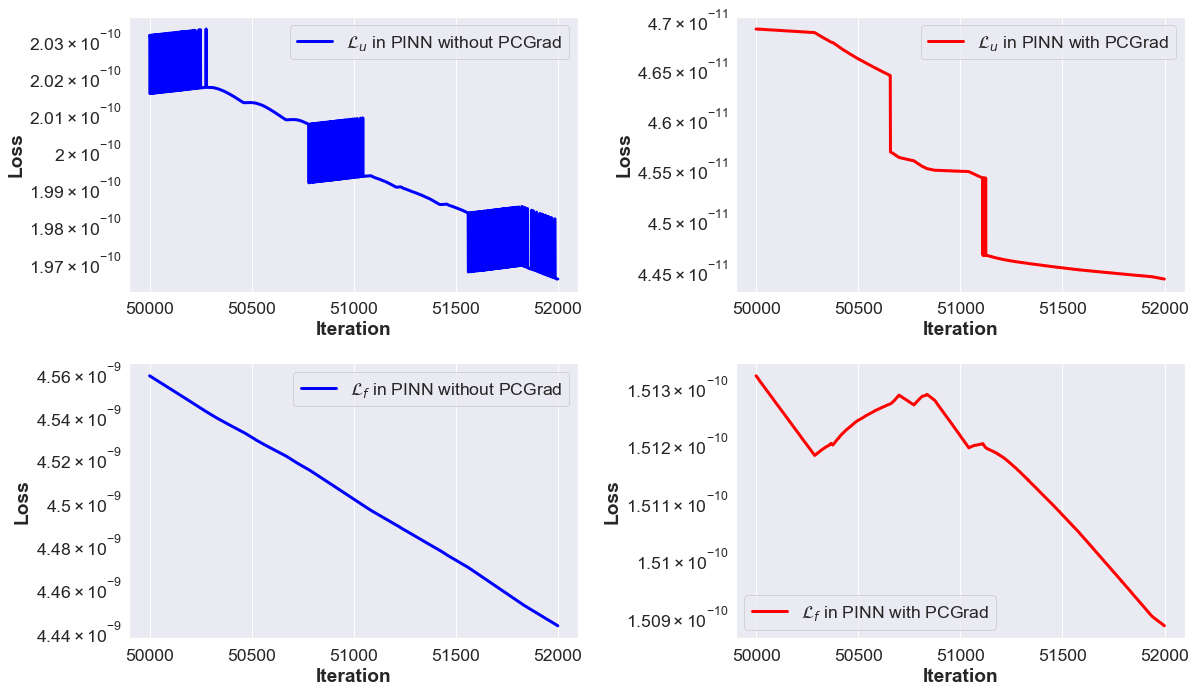

In [17]:
f, ax = plt.subplots(2, 2, figsize=(17, 10))

sns.lineplot(x = iterations_range, y = pinn_loss_log[50000:52000, 0], linewidth = 3, color='blue',
             label=r'$\mathcal{L}_u$ in PINN without PCGrad', ax = ax[0][0])

ax[0][0].set(yscale="log")
ax[0][0].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[0][0].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_pcgrad_loss_log[50000:52000, 0], linewidth = 3, color='red', 
             label=r'$\mathcal{L}_u$ in PINN with PCGrad', ax = ax[0][1])

ax[0][1].set(yscale="log")
ax[0][1].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[0][1].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_loss_log[50000:52000, 1], linewidth = 3, color='blue',
             label=r'$\mathcal{L}_f$ in PINN without PCGrad', ax = ax[1][0])

ax[1][0].set(yscale="log")
ax[1][0].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[1][0].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_pcgrad_loss_log[50000:52000, 1], linewidth = 3, color='red', 
             label=r'$\mathcal{L}_f$ in PINN with PCGrad', ax = ax[1][1])

ax[1][1].set(yscale="log")
ax[1][1].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[1][1].set_ylabel("Loss", fontdict=dict(weight='bold'))


plt.tight_layout()
plt.savefig('loss_convergence_demonstration_small_homo.pdf')

#### Comparison of loss 

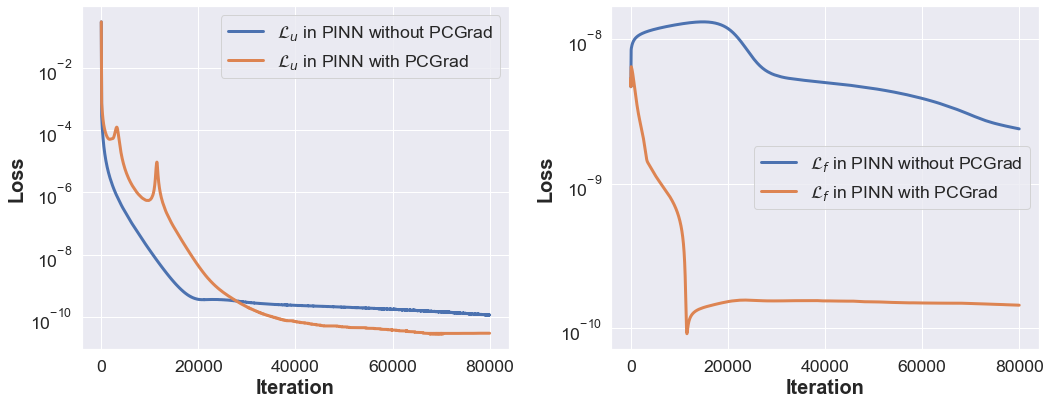

In [18]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration", fontdict=dict(weight='bold'), fontsize=20)
axes[0].set_ylabel("Loss", fontdict=dict(weight='bold'), fontsize=20)

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = pinn_loss_log[:, 1],  linewidth = 3, 
             label = "$\mathcal{L}_f$ in PINN without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = pinn_pcgrad_loss_log[:, 1],  linewidth = 3, 
             label = "$\mathcal{L}_f$ in PINN with PCGrad", ax = axes[1])
axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration", fontdict=dict(weight='bold'), fontsize=20)
axes[1].set_ylabel("Loss", fontdict=dict(weight='bold'), fontsize=20)

plt.tight_layout()
plt.savefig("performance_comparison_small_homo.pdf")

### Solution quality comparison

#### Load solver solution

In [19]:
matlab_solver_solution_df = pd.read_csv('homo_80000.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [20]:
matlab_solver_solution_df.head()

,time,state_0,state_1,state_2
0,16,0.99794,0.000894,0.001161
1,32,0.99589,0.001785,0.002321
2,48,0.99385,0.002673,0.003480
3,64,0.99180,0.003557,0.004639
4,80,0.98977,0.004439,0.005796


In [21]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [22]:
matlab_solver_solution_df.head()

,state_0,state_1,state_2
0,0.99794,0.000894,0.001161
1,0.99589,0.001785,0.002321
2,0.99385,0.002673,0.003480
3,0.99180,0.003557,0.004639
4,0.98977,0.004439,0.005796


#### Load MCS solution

In [23]:
MCS_solution_df = pd.read_csv('MCS_homo_80000.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [24]:
MCS_solution_df.head()

,time,state_0,state_1,state_2
0,16.0,0.997984,0.000895,0.001121
1,32.0,0.995997,0.001729,0.002274
2,48.0,0.993874,0.002629,0.003497
3,64.0,0.991758,0.003541,0.004701
4,80.0,0.989762,0.004375,0.005863


In [25]:
MCS_solution_df.drop(labels='time', inplace=True, axis = 1)

In [26]:
MCS_solution_df.head()

,state_0,state_1,state_2
0,0.997984,0.000895,0.001121
1,0.995997,0.001729,0.002274
2,0.993874,0.002629,0.003497
3,0.991758,0.003541,0.004701
4,0.989762,0.004375,0.005863


#### PINN Solver

In [27]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

ub = 80000
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 

In [28]:
%%time

y_pred = PINN_solver.predict(x_star)
y_pred_pcgrad = PINN_solver_pcgrad.predict(x_star)

Wall time: 3.99 ms


In [29]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

#### Compare PINN predictions with Matlab solver

In [30]:
sns.set_style("white")
plt.rcParams['legend.fontsize'] = 12

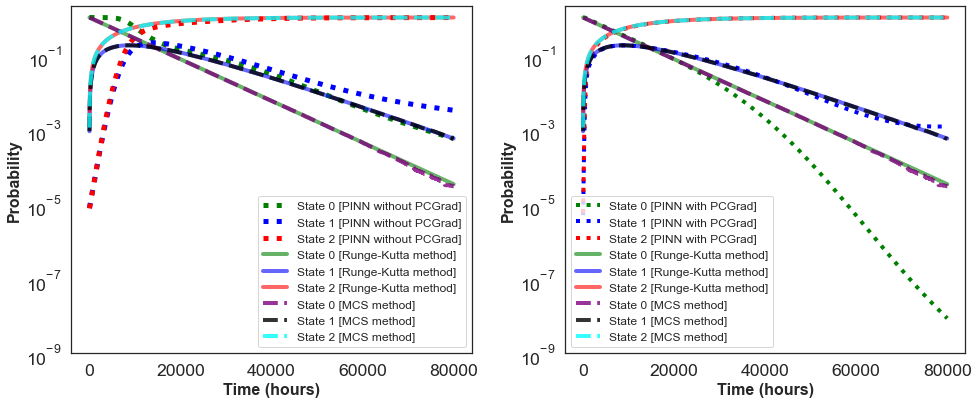

In [31]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0 [PINN without PCGrad]', linewidth = 5, color = 'green', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1 [PINN without PCGrad]', linewidth = 5, color = 'blue', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2 [PINN without PCGrad]', linewidth = 5, color = 'red', 
             linestyle='dotted', ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta method]', color = 'green',
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta method]', color = 'blue', 
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta method]', color = 'red', 
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_0'], 
             label = 'State 0 [MCS method]', color = 'purple', linestyle='--',
             alpha=0.8, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_1'], 
             label = 'State 1 [MCS method]', color = 'black', linestyle='--',
             alpha=0.8, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_2'], 
             label = 'State 2 [MCS method]', color = 'cyan', linestyle='--',
             alpha=0.8,  linewidth = 4, ax=ax[0])

ax[0].set_yscale("log")
ax[0].set_ylim([1e-9, 2])
ax[0].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[0].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'State 0 [PINN with PCGrad]', 
             color = 'green', linestyle='dotted', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'State 1 [PINN with PCGrad]', 
             color = 'blue', linestyle='dotted', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'State 2 [PINN with PCGrad]', 
             color = 'red', linestyle='dotted', linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta method]', color = 'green',
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta method]', color = 'blue', 
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta method]', color = 'red', 
             alpha=0.6, dashes=True, linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_0'], 
             label = 'State 0 [MCS method]', color = 'purple', linestyle='--',
             alpha=0.8, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_1'], 
             label = 'State 1 [MCS method]', color = 'black', linestyle='--',
             alpha=0.8, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['state_2'], 
             label = 'State 2 [MCS method]', color = 'cyan', linestyle='--',
             alpha=0.8,  linewidth = 4, ax=ax[1])

ax[1].set_yscale("log")
ax[1].set_ylim([1e-9, 2])
ax[1].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[1].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout()
plt.savefig("comparison_small_homo.pdf")

In [32]:
y_pred_df.tail()

,state_0,state_1,state_2
4995,0.000576,0.003273,0.996152
4996,0.000575,0.003271,0.996154
4997,0.000574,0.003269,0.996157
4998,0.000574,0.003267,0.996159
4999,0.000573,0.003265,0.996162


In [33]:
y_diff_matlab = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad_matlab = matlab_solver_solution_df - y_pred_pcgrad_df

y_diff_MCS = MCS_solution_df - y_pred_df
y_diff_pcgrad_MCS = MCS_solution_df - y_pred_pcgrad_df

In [34]:
y_diff_matlab.head()

,state_0,state_1,state_2
0,-0.002045,0.000886,0.001153
1,-0.004094,0.001777,0.002313
2,-0.006134,0.002665,0.003472
3,-0.008183,0.003549,0.004630
4,-0.010213,0.004430,0.005788


#### Generate histogram of prediction difference with respect to each state

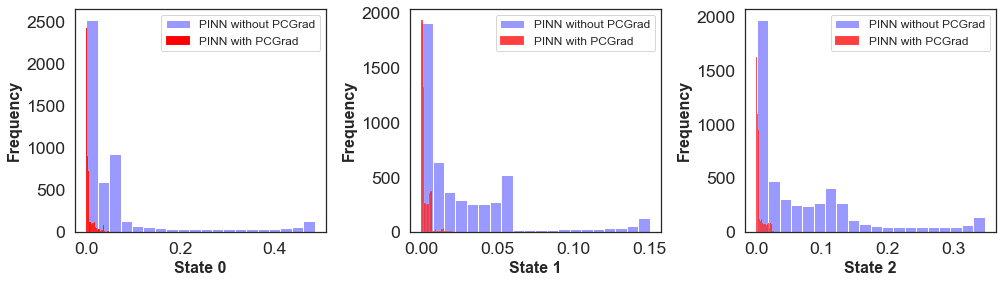

In [36]:
f, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(np.abs(y_diff_matlab['state_0']), bins=20, ax=axes[0], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['state_0']), bins=20, ax=axes[0], alpha=1, color='red', label='PINN with PCGrad')


#plt.axvline(x=np.mean(np.abs(y_diff['state_0'])), linewidth=2, linestyle="--", alpha=0.6, 
#            color='blue', label='Mean of no PCGrad')

axes[0].legend()
axes[0].set_xlabel('State 0', fontdict=dict(weight='bold'), fontsize=16)
axes[0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff_matlab['state_1']), bins=20, ax=axes[1], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['state_1']), bins=20, ax=axes[1], color='red', label='PINN with PCGrad')
axes[1].legend()
axes[1].set_xlabel('State 1', fontdict=dict(weight='bold'), fontsize=16)
axes[1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

sns.histplot(np.abs(y_diff_matlab['state_2']), bins=20, ax=axes[2], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['state_2']), bins=20, ax=axes[2], color='red', label='PINN with PCGrad')
axes[2].legend()
axes[2].set_xlabel('State 2', fontdict=dict(weight='bold'), fontsize=16)
axes[2].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout(pad=0.5)
plt.savefig("histogram_small_homo.pdf")

#### Compare RMSE

In [37]:
y_diff_matlab['mse'] = y_diff_matlab.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_matlab['rmse'] = y_diff_matlab['mse'].apply(np.sqrt)

y_diff_pcgrad_matlab['mse'] = y_diff_pcgrad_matlab.apply(lambda x: x['state_0']**2 + x['state_1']**2 + \
                                                         x['state_2']**2, axis = 1)
y_diff_pcgrad_matlab['rmse'] = y_diff_pcgrad_matlab['mse'].apply(np.sqrt)

In [38]:
y_diff_MCS['mse'] = y_diff_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_MCS['rmse'] = y_diff_MCS['mse'].apply(np.sqrt)

y_diff_pcgrad_MCS['mse'] = y_diff_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + \
                                                         x['state_2']**2, axis = 1)
y_diff_pcgrad_MCS['rmse'] = y_diff_pcgrad_MCS['mse'].apply(np.sqrt)

In [39]:
print ('RMSE between PINN without PCGrad and matlab solver is', np.mean(y_diff_matlab['rmse']))
print ('RMSE between PINN with PCGrad and matlab solver is', np.mean(y_diff_pcgrad_matlab['rmse']))

print ('RMSE of between PINN without PCGrad and MCS simulations is', np.mean(y_diff_MCS['rmse']))
print ('RMSE of between PINN with PCGrad and MCS simulations is', np.mean(y_diff_pcgrad_MCS['rmse']))

RMSE between PINN without PCGrad and matlab solver is 0.1111387904623298
RMSE between PINN with PCGrad and matlab solver is 0.008291605013509519
RMSE of between PINN without PCGrad and MCS simulations is 0.1114077988095561
RMSE of between PINN with PCGrad and MCS simulations is 0.008440117451299396


In [40]:
print ('RMSE between PINN without PCGrad and matlab solver before 60000 is', np.mean(y_diff_matlab['rmse'][:3749]))
print ('RMSE between PINN with PCGrad and matlab solver before 60000 is', np.mean(y_diff_pcgrad_matlab['rmse'][:3749]))

print ('RMSE between PINN without PCGrad and MCS simulations before 60000 is', np.mean(y_diff_MCS['rmse'][:3749]))
print ('RMSE between PINN with PCGrad and MCS simulations before 60000 is', np.mean(y_diff_pcgrad_MCS['rmse'][:3749]))


print ('RMSE between PINN without PCGrad and matlab solver after 60000 is', np.mean(y_diff_matlab['rmse'][3749:]))
print ('RMSE between PINN with PCGrad and matlab solver after 60000 is', np.mean(y_diff_pcgrad_matlab['rmse'][3749:]))

print ('RMSE between PINN without PCGrad and MCS simulations after 60000 is', np.mean(y_diff_MCS['rmse'][3749:]))
print ('RMSE between PINN with PCGrad and MCS simulations after 60000 is', np.mean(y_diff_pcgrad_MCS['rmse'][3749:]))

RMSE between PINN without PCGrad and matlab solver before 60000 is 0.14614567277033752
RMSE between PINN with PCGrad and matlab solver before 60000 is 0.01082606303772342
RMSE between PINN without PCGrad and MCS simulations before 60000 is 0.1464949477380842
RMSE between PINN with PCGrad and MCS simulations before 60000 is 0.011031438058050447
RMSE between PINN without PCGrad and matlab solver after 60000 is 0.006230076015708876
RMSE between PINN with PCGrad and matlab solver after 60000 is 0.0006963347235191894
RMSE between PINN without PCGrad and MCS simulations after 60000 is 0.00625854114924192
RMSE between PINN with PCGrad and MCS simulations after 60000 is 0.0006744412285098644
